# Download Data

In [1]:
# Group members:
# Yijie, Tang   2021226545 YXT140930 yxt140930@utdallas.edu
# Shiyou, Yan   2021459331 SXY180032 sxy180032@utdallas.edu
# Nguyen, Hoang 2021690004 HDN220000 hdn220000@utdallas.edu
# Yu-Chen, Lin  2021719530 YXL220044 yxl220044@utdallas.edu
# Kuei-Yu, Tsai 2021733495 KXT230002 kxt230002@utdallas.edu

import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
import numpy as np
from sympy import diff, symbols, exp
import gdown
import matplotlib.pyplot as plt

# The original dataset was downloaded from Kaggel: https://www.kaggle.com/datasets/harshsingh2209/nvidia-stock-pricing-20172022
# We added another column "Next Close", which is the next day's closing price
download_url = 'https://drive.google.com/uc?export=download&id=1xPZuI0X3mFF0st6RpM-PuewbwcDKzsVm'
data_file_path = 'NVDA.csv'
gdown.download(download_url, data_file_path, quiet=False)
stock_data = pd.read_csv(data_file_path, index_col=0)

Downloading...
From: https://drive.google.com/uc?export=download&id=1xPZuI0X3mFF0st6RpM-PuewbwcDKzsVm
To: /content/NVDA.csv
100%|██████████| 98.9k/98.9k [00:00<00:00, 50.0MB/s]


# Hyperparameters

In [2]:
epochs = 100
learning_rate = 1e-4
num_hidden_layers = 13

network_config = [
    {"type":"input", "units": 3},
    {"type": "rnn", "hidden": num_hidden_layers, "output": 1}
]

# Preprocess Data

In [3]:
def calc_mean_squared_error(actual_vals, pred_vals):
    return np.mean((actual_vals - pred_vals) ** 2)

def mean_squared_error_gradient(actual_vals, predicted_vals):
    return predicted_vals - actual_vals

def calc_mean_squared_error_grad(actual_vals, pred_vals):
    return pred_vals - actual_vals

def normalize_data(data, features, target):
    scaler = StandardScaler()
    data[features] = scaler.fit_transform(data[features])
    return data

def divide_data(data, features, target, seed=0):
    np.random.seed(seed)
    splits = [int(.7 * len(data)), int(.85 * len(data))]
    split_data = np.split(data, splits)
    return [[d[features].to_numpy(), d[[target]].to_numpy()] for d in split_data]

# Define features and target
features = ["Open", "Close", "Volume"]
target = "Next Close"

# Normalize the dataset
normalized_data = normalize_data(stock_data, features, target)

# Divide data into training, validation, and testing sets
divided_data = divide_data(normalized_data, features, target)
(train_feats, train_target), (valid_feats, valid_target), (test_feats, test_target) = divided_data

# Model

In [4]:
def initialize_parameters(layer_config):
    layers = []
    np.random.seed(0)

    for i in range(1, len(layer_config)):
        units_prev = layer_config[i - 1]["units"]
        hidden_units = layer_config[i]["hidden"]
        output_units = layer_config[i]["output"]

        k = 1 / math.sqrt(hidden_units)

        input_weights = np.random.rand(units_prev, hidden_units) * 2 * k - k
        hidden_weights = np.random.rand(hidden_units, hidden_units) * 2 * k - k
        hidden_bias = np.random.rand(1, hidden_units) * 2 * k - k
        output_weights = np.random.rand(hidden_units, output_units) * 2 * k - k
        output_bias = np.random.rand(1, output_units) * 2 * k - k

        layers.append([input_weights, hidden_weights, hidden_bias, output_weights, output_bias])

    return layers


def forward_pass(x, layers):
    hidden_outputs = []
    final_outputs = []

    for layer in layers:
        input_weights, hidden_weights, hidden_bias, output_weights, output_bias = layer
        hidden_layer = np.zeros((x.shape[0], input_weights.shape[1]))
        output_layer = np.zeros((x.shape[0], output_weights.shape[1]))

        for j in range(x.shape[0]):
            input_x = np.dot(x[j][np.newaxis, :], input_weights)
            hidden_x = input_x + np.dot(hidden_layer[max(j - 1, 0)][np.newaxis, :], hidden_weights) + hidden_bias
            hidden_x = np.tanh(hidden_x)
            hidden_layer[j, :] = hidden_x

            output_x = np.dot(hidden_x, output_weights) + output_bias
            output_layer[j, :] = output_x

        hidden_outputs.append(hidden_layer)
        final_outputs.append(output_layer)

    return hidden_outputs, final_outputs[-1]


def backward_pass(layers, x, learning_rate, gradients, hidden_outputs):
    for i, layer in enumerate(layers):
        input_weights, hidden_weights, hidden_bias, output_weights, output_bias = layer
        hidden_output = hidden_outputs[i]
        input_weights_gradient, hidden_weights_gradient, hidden_bias_gradient, output_weights_gradient, output_bias_gradient = 0, 0, 0, 0, 0
        next_hidden_gradient = None

        for j in reversed(range(x.shape[0])):
            output_gradient = gradients[j][np.newaxis, :]

            output_weights_gradient += np.dot(hidden_output[j][:, np.newaxis], output_gradient)
            output_bias_gradient += output_gradient

            hidden_gradient = np.dot(output_gradient, output_weights.T)

            if j < x.shape[0] - 1:
                next_hidden_gradient = np.dot(next_hidden_gradient, hidden_weights.T)
                hidden_gradient += next_hidden_gradient

            tanh_derivative = 1 - hidden_output[j][np.newaxis, :] ** 2
            hidden_gradient *= tanh_derivative

            next_hidden_gradient = hidden_gradient.copy()

            if j > 0:
                hidden_weights_gradient += np.dot(hidden_output[j - 1][:, np.newaxis], hidden_gradient)
                hidden_bias_gradient += hidden_gradient

            input_weights_gradient += np.dot(x[j][:, np.newaxis], hidden_gradient)

        # Normalize learning rate by number of sequence elements
        learning_rate /= x.shape[0]
        # Update parameters
        input_weights -= input_weights_gradient * learning_rate
        hidden_weights -= hidden_weights_gradient * learning_rate
        hidden_bias -= hidden_bias_gradient * learning_rate
        output_weights -= output_weights_gradient * learning_rate
        output_bias -= output_bias_gradient * learning_rate
        # Update layers list
        layers[i] = [input_weights, hidden_weights, hidden_bias, output_weights, output_bias]

    return layers

# Training

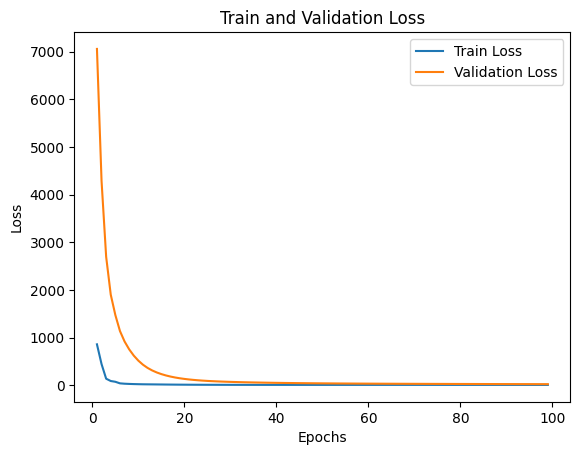

In [5]:
def run_training_epoch(input_data, output_data, network_layers, learning_rate):
    sequence_length = 7
    epoch_loss = 0
    for j in range(input_data.shape[0] - sequence_length):
        sequence_x = input_data[j:(j+sequence_length),]
        sequence_y = output_data[j:(j+sequence_length),]
        hidden_states, outputs = forward_pass(sequence_x, network_layers)
        gradients = mean_squared_error_gradient(sequence_y, outputs)
        updated_layers = backward_pass(network_layers, sequence_x, learning_rate, gradients, hidden_states)
        epoch_loss += calc_mean_squared_error(sequence_y, outputs)
    return epoch_loss / len(input_data)

def train_neural_network(training_input, training_output, validation_input, validation_output, network_layers, learning_rate, epochs):
    train_losses = []
    validation_losses = []

    for epoch in range(epochs):
        train_loss = run_training_epoch(training_input, training_output, network_layers, learning_rate)
        train_losses.append(train_loss)
        validation_loss = run_training_epoch(validation_input, validation_output, network_layers, learning_rate)
        validation_losses.append(validation_loss)

    return train_losses, validation_losses

network_layers = initialize_parameters(network_config)

train_losses, validation_losses = train_neural_network(train_feats, train_target, valid_feats, valid_target, network_layers, learning_rate, epochs)

# Plotting
plt.plot(range(1, epochs), train_losses[1:], label='Train Loss')
plt.plot(range(1, epochs), validation_losses[1:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.savefig(f"loss_plot_lr_{learning_rate}_hidden_layers_{num_hidden_layers}_epochs_{epochs}.png")
plt.show()

# Evaluation

In [6]:
# Prediction and Evaluation
def predict_and_evaluate(data_input, data_output, network_layers):
    hidden_states, predictions = forward_pass(data_input, network_layers)
    mse_error = calc_mean_squared_error(data_output, predictions)
    for i in range(len(data_input)):
        print(f"Predicted: {predictions[i][0]:.2f}, Actual: {data_output[i][0]:.2f}")
    print(f"Mean Squared Error on Evaluation Data: {mse_error:.2f}")

    return mse_error

mse_err = predict_and_evaluate(test_feats, test_target, network_layers)

Predicted: 202.57, Actual: 222.42
Predicted: 221.61, Actual: 223.41
Predicted: 220.40, Actual: 222.42
Predicted: 220.13, Actual: 219.00
Predicted: 219.85, Actual: 211.13
Predicted: 215.05, Actual: 212.46
Predicted: 216.85, Actual: 219.41
Predicted: 218.83, Actual: 224.82
Predicted: 221.03, Actual: 220.81
Predicted: 219.71, Actual: 216.60
Predicted: 218.14, Actual: 206.99
Predicted: 213.77, Actual: 205.17
Predicted: 212.66, Actual: 207.16
Predicted: 213.25, Actual: 207.42
Predicted: 213.34, Actual: 197.32
Predicted: 207.41, Actual: 204.51
Predicted: 211.32, Actual: 207.00
Predicted: 211.91, Actual: 210.75
Predicted: 216.22, Actual: 208.31
Predicted: 213.25, Actual: 206.95
Predicted: 211.87, Actual: 206.71
Predicted: 212.98, Actual: 209.39
Predicted: 214.34, Actual: 217.46
Predicted: 218.40, Actual: 218.62
Predicted: 219.06, Actual: 222.22
Predicted: 219.72, Actual: 222.90
Predicted: 220.46, Actual: 221.03
Predicted: 219.91, Actual: 226.92
Predicted: 221.14, Actual: 227.26
Predicted: 221

# Record the Result

In [7]:
# Open a text file to append the results
with open("experiment_results.txt", "a") as file:
    # Write the results to the file
    file.write(f"Experiment with Learning Rate: {learning_rate}, Hidden Layers: {num_hidden_layers}\n")
    file.write(f"Train Loss: {train_losses[-1]}\n")
    file.write(f"Validation Loss: {validation_losses[-1]}, Validation RMSE: {mse_err:.2f}\n\n")